# Defect Detection on Metallic Surface Images

Alexandra AMIENS  Julieva COHEN-SORS   Louise DIETRICH  Claire ZOUAOUI

## Context

This notebook presents a use case of applying neural networks to classify 6 types of defect on metallic surface images.

We are using a small dataset (90 images) to build, train and validate neural network models. Then we will apply our models to the full dataset (1800 images).

## Possible Business Use Cases

Quality control is a compulsory step of a manufactoring process. Producing goods that fall below quality standards of a production line is costly in time, money and resources.

Artificial Intelligence has gained ground in all steps of manufacturing workflows from procurement forecast, to shipment tracking, or predicting downtime.

Manufacturing companies are leveraging AI in their production lines to improve the overall production efficiency. 

This notebook presents a possible application of quality control with neural network models. 
The expected value gains offered by AI-enhanced quality control are: 

* Optimizing production capacity;
* Decreasing production time;
* Lowering the costs of the whole manufacturing process;
* Improving the safety of goods.

## Detection Process

We are going to build convolutional neural networks to detect defects on metallic images. Our methodology will cover the following steps: 

1. Data preparation
2. Data exploration
    * Description of the dataset
    * Data Visualisation
3. Model building on the reduced dataset: convolutional neural networks on pretrained models
    1. Model 1: resnet18
        * Initialize the model parameters
        * Loading data: data augmentation
        * Build the model structure with training and validation steps
            * Transfer learning: 
                * Feature Extraction
                * Optimizer and learning rate scheduler    
        * Run and validate the model
    2. Model 2: resnet50    
    3. Model 3: vgg11_bn 
    4. Ensemble methods: 
        * Majority vote of our 3 pretrained models
        * Combining 2 best models into an Ensembling Classifier
            * Trial 1: resnet18 and vgg11_bn
            * Trial 2: resnet50 and vgg11_bn
4. Deploy models on the whole dataset
    1. Pretrained CNN models: 
        * vgg11_bn
        * Rnsemble classifier combining 'vgg11_rb' and 'resnet50'
    3. CNN Built from Scratch
5. Visualize the predictions

The best found accuracy on the whole dataset was achieved by the ensemble classifier combining 'vgg11_rb' and 'resnet50' at <b>98.9%</b>. As a comparison, our CNN built from scratch performed at 96.3% accuracy.

### 1. Data Preparation

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
import torch
import os
from torchvision import datasets, transforms, models
from skimage import io, transform
import matplotlib.pyplot as plt
from __future__ import print_function
from __future__ import division
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler as lr_scheduler
import torchvision
import time
import copy

<span style="color:#008B8B"> <b>Please note</b> that this notebook was conceived in Google Colab to benefit from computations on GPU. Some code lines may not work when running the script in Jupyter/Anaconda.</span>

In [2]:
# Access to Google Drive File
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### 1.1. Transformations to apply to each image: resize and transformation to tensor

We are applying basic transformations to discover the dataset.

In [3]:
train_trainsforms = transforms.Compose([transforms.Resize((200,200)),
                                            transforms.ToTensor(),
                                            transforms.Normalize((0.5,), (0.5,)),])
    
test_trainsforms = transforms.Compose([transforms.Resize((200,200)),
                                           transforms.ToTensor(),
                                           transforms.Normalize((0.5,), (0.5,)),])

#### 1.2. Charge and load train and test datasets

In [4]:
data_train_path='/content/drive/MyDrive/Data_train'
data_test_path='/content/drive/MyDrive/Data_test'
database_path = '/content/drive/MyDrive/Database'

In [5]:
train_data = datasets.ImageFolder(data_train_path,transform=train_trainsforms)
test_data = datasets.ImageFolder(data_test_path,transform=test_trainsforms)

In [6]:
#the loader loads each time 64 images for one training iteration
train_loader =  torch.utils.data.DataLoader(train_data,batch_size=64,shuffle=True)
test_loader =  torch.utils.data.DataLoader(test_data,batch_size=64,shuffle=True)

### 2. Data Exploration

#### 2.1. Train And Test Datasets Size

In [7]:
#Number of items in training set
num_train = len(train_data)
indices = list(range(num_train))
print('The number of items in training set is ', num_train)

The number of items in training set is  60


In [8]:
#Number of items in test set
num_test = len(test_data)                               
indices = list(range(num_test))
print('The number of items in testing set is ', num_test)

The number of items in testing set is  30


#### 2.1. Mean And Standard Deviation

We are computing the mean and standard deviation of each set. This will help us dataset when we will applying data augmentation steps prior to model building but we'll discuss this further.

In [9]:
# Training set: mean and standard deviation
train_tensor=torch.cat([x for (x,_)in train_loader])
means_train=train_tensor.mean((0,2,3))
std_train =train_tensor.mean((0,2,3))
print('The mean of the training set is',means_train)
print('The standard deviation of the training set is',std_train)

The mean of the training set is tensor([0.0326, 0.0326, 0.0326])
The standard deviation of the training set is tensor([0.0326, 0.0326, 0.0326])


In [10]:
# Training set: mean and standard deviation
test_tensor=torch.cat([x for (x,_)in test_loader])
means_test=test_tensor.mean((0,2,3))
std_test =test_tensor.mean((0,2,3))
print('The mean of the training set is',means_test)
print('The standard deviation of the training set is',std_test)

The mean of the training set is tensor([0.1555, 0.1555, 0.1555])
The standard deviation of the training set is tensor([0.1555, 0.1555, 0.1555])


#### 2.2. Types Of Defects On Metal Images

In [11]:
train_data.class_to_idx

{'Crazing': 0,
 'Inclusions': 1,
 'Patches': 2,
 'PittedSurface': 3,
 'RolledInScale': 4,
 'Scratches': 5}

#### 2.3. Explore Image Data

In [12]:
dataiter = iter(train_loader)
images, labels = dataiter.next() # Split Between Images Tensors And The Output Labels
images = images[:,0,:,:]
print(images.shape)
print(labels.shape)

torch.Size([60, 200, 200])
torch.Size([60])


The first line prints the size of the tensor of images: there are 60 images in the train dataset.
Each image has 200 x 200 pixels
As we have gray-scale images, we have 1 cannal of colors as opposed to 3 for RGB images.

In [13]:
#depth, width, height
images[1].numpy().shape

(200, 200)

The images are sized to 200 x 200 pixels.

In [14]:
# We have 6 classes corresponding to 6 types of defects. The loader codes these classes from 0 to 5.
print(labels)

tensor([5, 3, 3, 2, 5, 1, 4, 0, 3, 0, 2, 4, 4, 0, 5, 0, 1, 3, 4, 5, 5, 0, 4, 4,
        1, 5, 2, 4, 0, 2, 0, 3, 2, 2, 2, 2, 5, 5, 1, 1, 1, 2, 0, 4, 0, 2, 3, 5,
        1, 3, 1, 0, 3, 1, 3, 3, 5, 1, 4, 4])


#### 2.4. Visualize Image Data

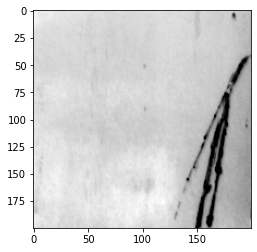

In [15]:
#print the first image by using the function imshow of matplotlib
plt.imshow(images[0], cmap='gray_r');

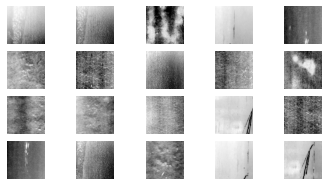

In [16]:
#plot 20 images
figure = plt.figure()
num_of_images = 20
for index in range(1, num_of_images + 1):
    plt.subplot(5, 5, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

#### 2.5. Visualize Defect Distribution On The Datasets
Let’s make sure the distribution of defects is equally split in the 6 classes in the Train and Test sets

In [17]:
# Create Dictionary To Map An Index To A Defect
id_to_class = {v: k for k, v in train_data.class_to_idx.items()}
id_to_class

{0: 'Crazing',
 1: 'Inclusions',
 2: 'Patches',
 3: 'PittedSurface',
 4: 'RolledInScale',
 5: 'Scratches'}

In [18]:
# Create Dictionary To Count Classes In Train and Test Sets
def get_class_distribution(dataset):
    # Dictionary To Initialize Count Of Classes To 0
    # Loop over the dataset and increment the counter by 1 for every class label
    count_dict = {k:0 for k,v in dataset.class_to_idx.items()}    
    for _, label_id in dataset:
        label = id_to_class[label_id]
        count_dict[label] += 1
    return count_dict

In [19]:
# Create A Plot Function
# **kwargs is used to construct subplots which require passing the ax argument in seaborn
def plot_from_dict(dictionary, plot_title, **kwargs):
    return sns.barplot(data = pd.DataFrame.from_dict([dictionary]).melt(),
                       x = "variable", y="value", hue="variable", **kwargs).set_title(plot_title),plt.figure(figsize=(15,8))

(Text(0.5, 1.0, 'Train Data'), <Figure size 1080x576 with 0 Axes>)

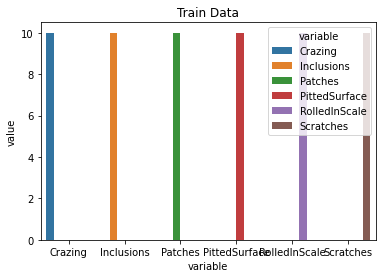

<Figure size 1080x576 with 0 Axes>

In [20]:
# Plot Defect Distribution For Train Data
plot_from_dict(get_class_distribution(train_data), "Train Data")

(Text(0.5, 1.0, 'Test Data'), <Figure size 1080x576 with 0 Axes>)

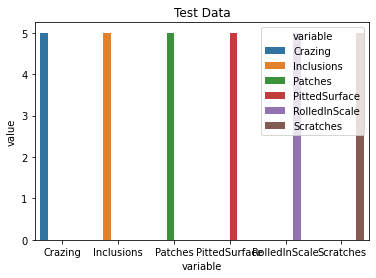

<Figure size 1080x576 with 0 Axes>

In [21]:
# Plot Defect Distribution For Test Data
plot_from_dict(get_class_distribution(test_data), "Test Data")

Each defect is evenly represented in the Test Set and the Train sets.

# 3. Model building: Convolutional Neural Networks

Why Convolutional Neural Networks?

We have seen that our images have 200 x 200 pixels. This means that the number of neurons needed in the input layer is 40,000. This is computationally expensive and ineffective.

We're going to introduce Convolutional Neural Network or CNN to handle the computations because they can extract the feature of image and convert it into lower dimension without loosing its characteristics.

<span style="color:  #C70039;">Here, we're going to use the <b>small sample of the dataset (90 images)</b> as used so far to build and train the models.</span>

<span style="color:  #C70039;">Once our models are implemented, we'll apply it to the whole dataset. We'll also compare the pretrained models with a model build from scratch.</span>

<b> Here's our methodology: </b>

* <b> Select and train pretrained models </b>

We are going to use 3 PyTorch pretrained CNN models trained on the 1000-class Imagenet dataset rather than training an entire CNN from scatch because the PyTorch models are trained on very large dataset (ImageNet is made up of 1.2 million images with 10 different classes).

* <b>Transfer learning: </b>
    * <b>feature extraction</b>

Since we're using pretrained models, we need to adapt the CNN architecture to our own data. This step is called transfer learning. Here we're using feature extraction, updating the final layer weights of the pretrained models to fit our data.
  * <b>Select appropriate optimizers and learning rate schedulers</b>
 
* <b>Run the models and evaluate accuracy</b>
* <b>Ensembling Methods</b>: 
    * <b>Majority voting method </b>with the 3 models
    * <b>Ensembling Classifier</b>: combine the 2 best models into a unique classifier using an ensembling method</b>

Finally, we'll use the best found models on the whole dataset. And compare them with a model built from scratch.

## Model 1: resnet18

#### 1. Initialize the model parameters

The first model we are going to train is "resnet18"

In [22]:
data_dir = os.getcwd()

# We're going to use a pretrained model: resnet18
model_name = "resnet18"

# Number of classes in the dataset
num_classes = 6

# Batch size for training
batch_size = 64

# Number of epochs to train for
num_epochs = 50

# Number of pixels
input_size = 224

#### 2. Load Data

We're performing a few data augmentation steps. To normalize the training and test sets, we're using the mean and standard deviation found earlier. We're creating a dictionary holding the two sets.

In [23]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomVerticalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.0326, 0.0326, 0.0326], [0.0326, 0.0326, 0.0326])
    ]),
    'val': transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.1555, 0.1555, 0.1555], [0.1555, 0.1555, 0.1555])
    ]),
}

print("Initializing Datasets and Dataloaders...")

# Create training and validation datasets
image_datasets = {'train':datasets.ImageFolder(data_train_path, data_transforms['train']),
                  'val':datasets.ImageFolder(data_test_path, data_transforms['val'])}
#image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
# Create training and validation dataloaders
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'val']}

# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Initializing Datasets and Dataloaders...


#### 3. Build the model structure with training and validation steps

This function takes as input a PyTorch model, a dictionary of dataloaders, a loss function, an optimizer for training, a learning rate scheduler, a number of epochs to train and validate for.

In [24]:
def train_model(model, dataloaders, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
            
                    # Get model outputs and calculate loss
                    #  In train mode we calculate the loss by summing the final output and the auxiliary output
                    #  But in testing we only consider the final output.
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)  
                # Use a learning rate scheduler in training
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

#### 3.1. Transfer Learning: Feature Extraction

Since we are using a pretrained PyTorch model, we're going to apply transfer learning to adapt the model to our dataset.
There are two ways to perform transfer learning:

* <b>Finetuning</b>: it consists in updating all of the pretrained model's parameters to our specific classification task.
* <b>Feature extraction</b>: it consists in updating the parameters of the final layer to have the same output size as the number of different class of our own classification problem. This last fully connected layer is replaced with a new one with random weights and <b>only this layer is trained</b>.

Here we are performing feature extraction. By default, when we load a pretrained model all of the parameters have <mark style="background-color:  #d5d8dc ">.requires_grad=True</mark> to compute the gradients for each layer. 

Since we are using feature extraction, we will set  <mark style="background-color:  #d5d8dc ">.requires_grad=False </mark> so that the gradients are not computed in backward().
We will manually initialize the final layer with random weights.

In [25]:
feature_extract = True
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [26]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0
    if model_name == "resnet18":
        """ Resnet18
        """
        model_ft = models.resnet18(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract) # Set Feature Extraction
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes) # Initialize final layer weights with our customer number of classes
        input_size = 224
        
    if model_name == "resnet50":
        """ Resnet50
        """
        model_ft = models.resnet50(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224
        
    elif model_name == "vgg":
        """ VGG11_bn
        """
        model_ft = models.vgg11_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    return model_ft, input_size

# Initialize the model for this run
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)

# Print the model we just instantiated
print(model_ft)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth



ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
 

#### 3.2. Create The Optimizer And Learning Rate Scheduler

The optimizer will update the parameters based on the computed gradients. The learning rate scheduler will adjust the learning rate based on the number of epochs.

Select the parameters to update. As we can see, only the parameters of the fully connected layer 'fc' are going to be updated since we are feature extracting.

In [27]:
# Send the model to GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_ft = model_ft.to(device)

# Gather the parameters to be optimized/updated in this run. 
# As we are feature extracting, we will only update the parameters that the initialize_model function has initialized,
# i.e. the parameters with requires_grad=True.
params_to_update = model_ft.parameters()
print("Parameters to learn:")
params_to_update = []
for name,param in model_ft.named_parameters():
    if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)

Parameters to learn:
	 fc.weight
	 fc.bias


We are using 'Adam' optimizer rather than 'SGD' since it helped improving our model performance. The running steps with 'SGD' were used in our draft phase and we are not are not showing them here.

In [28]:
# Define learning rate and weight decay over epochs
learning_rate = 0.01
weight_decay = 0.005

# Observe that only the parameters of the final layer are being optimized
optimizer_ft = optim.Adam(params_to_update, lr=learning_rate, betas=(0.9, 0.999), eps=1e-08, weight_decay=weight_decay)

# Setup the loss function
criterion = nn.CrossEntropyLoss()

# Setup the learning rate
lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer_ft, T_max=15, eta_min=learning_rate, last_epoch=-1, verbose=False)

#### 4. Run Model: Training And Validation Steps

In [29]:
model_res18 = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, lr_scheduler, num_epochs=num_epochs)

Epoch 0/49
----------
train Loss: 1.6803 Acc: 0.3333
val Loss: 2.1831 Acc: 0.1667

Epoch 1/49
----------
train Loss: 2.7427 Acc: 0.1833
val Loss: 1.7819 Acc: 0.1667

Epoch 2/49
----------
train Loss: 1.7544 Acc: 0.3667
val Loss: 1.6387 Acc: 0.1667

Epoch 3/49
----------
train Loss: 1.1571 Acc: 0.6667
val Loss: 1.9259 Acc: 0.2333

Epoch 4/49
----------
train Loss: 1.4936 Acc: 0.5667
val Loss: 1.8371 Acc: 0.2667

Epoch 5/49
----------
train Loss: 1.4334 Acc: 0.6000
val Loss: 1.4683 Acc: 0.3333

Epoch 6/49
----------
train Loss: 0.7510 Acc: 0.7000
val Loss: 1.3290 Acc: 0.4000

Epoch 7/49
----------
train Loss: 0.4226 Acc: 0.8500
val Loss: 1.5325 Acc: 0.4000

Epoch 8/49
----------
train Loss: 0.3521 Acc: 0.8500
val Loss: 1.9721 Acc: 0.4333

Epoch 9/49
----------
train Loss: 0.3910 Acc: 0.8667
val Loss: 2.3413 Acc: 0.2333

Epoch 10/49
----------
train Loss: 0.6775 Acc: 0.7333
val Loss: 2.4860 Acc: 0.3000

Epoch 11/49
----------
train Loss: 0.4711 Acc: 0.8000
val Loss: 2.4487 Acc: 0.2667

Ep

In [30]:
# Save model and state_dictionary: the trained parameters of the model
model_res18.to(device)
torch.save({'arch': 'res18',
            'state_dict': model_res18.state_dict()}, 
            'resnet18.pth')
# Save Model path to use it later
resnet18_path='/content/resnet18.pth'
checkpoint_res18 = torch.load(resnet18_path)

The best accuracy found by <mark style="background-color: Gainsboro">resnet18</mark> on the reduced dataset is <b>43.3%</b>.

## Model 2: resnet50

<mark style="background-color: Gainsboro">resnet50</mark> has the same architecture as resnet18 but has 50 layers.

In [31]:
model_name = 'resnet50'

In [32]:
# Initialize the model for this run
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)

print(model_ft)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth



ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1,

In [33]:
# Send the model to GPU
model_ft = model_ft.to(device)

# Gather the parameters to be optimized/updated in this run. 
params_to_update = model_ft.parameters()
print("Parameters to learn:")
params_to_update = []
for name,param in model_ft.named_parameters():
    if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)

Parameters to learn:
	 fc.weight
	 fc.bias


In [34]:
# Only the parameters of the final layer are being optimized
optimizer_ft = optim.Adam(params_to_update, lr=learning_rate, betas=(0.9, 0.999), eps=1e-08, weight_decay=weight_decay)

# Setup the learning rate
lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer_ft, T_max=15, eta_min=learning_rate, last_epoch=-1, verbose=False)

In [35]:
model_res50 = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, lr_scheduler, num_epochs=num_epochs)

Epoch 0/49
----------
train Loss: 1.8122 Acc: 0.2333
val Loss: 1.9117 Acc: 0.2000

Epoch 1/49
----------
train Loss: 2.4497 Acc: 0.6333
val Loss: 1.7124 Acc: 0.2667

Epoch 2/49
----------
train Loss: 2.3130 Acc: 0.2500
val Loss: 1.9312 Acc: 0.2333

Epoch 3/49
----------
train Loss: 2.0101 Acc: 0.5000
val Loss: 2.4270 Acc: 0.1000

Epoch 4/49
----------
train Loss: 1.5048 Acc: 0.6333
val Loss: 2.4572 Acc: 0.3333

Epoch 5/49
----------
train Loss: 1.1097 Acc: 0.7667
val Loss: 2.7484 Acc: 0.2000

Epoch 6/49
----------
train Loss: 1.7834 Acc: 0.5500
val Loss: 2.3434 Acc: 0.1667

Epoch 7/49
----------
train Loss: 0.7467 Acc: 0.7667
val Loss: 2.0962 Acc: 0.4333

Epoch 8/49
----------
train Loss: 0.2575 Acc: 0.9333
val Loss: 2.3897 Acc: 0.4000

Epoch 9/49
----------
train Loss: 0.3317 Acc: 0.9000
val Loss: 2.7750 Acc: 0.3667

Epoch 10/49
----------
train Loss: 0.4134 Acc: 0.9167
val Loss: 2.9431 Acc: 0.3000

Epoch 11/49
----------
train Loss: 0.4329 Acc: 0.8000
val Loss: 2.8617 Acc: 0.4000

Ep

In [36]:
# Save model and state_dictionary: the trained parameters of the model
model_res50.to(device)
torch.save({'arch': 'res50',
            'state_dict': model_res50.state_dict()}, 
            'resnet50.pth')
# Save Model path to use it later
resnet50_path='/content/resnet50.pth'
checkpoint_res50 = torch.load(resnet50_path)

The best found accuracy by <mark style="background-color: Gainsboro">resnet50</mark> is <b>43.3%</b>

## Model 3: VGG11_bn

In [37]:
model_name = 'vgg'

In [38]:
# Initialize the model for this run
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)

print(model_ft)

Downloading: "https://download.pytorch.org/models/vgg11_bn-6002323d.pth" to /root/.cache/torch/hub/checkpoints/vgg11_bn-6002323d.pth



VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): MaxPool2d(k

In [39]:
# Send the model to GPU
model_ft = model_ft.to(device)

# Gather the parameters to be optimized/updated in this run. 
params_to_update = model_ft.parameters()
print("Parameters to learn:")
params_to_update = []
for name,param in model_ft.named_parameters():
    if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)

Parameters to learn:
	 classifier.6.weight
	 classifier.6.bias


In [40]:
# Only the parameters of the final layer are being optimized
optimizer_ft = optim.Adam(params_to_update, lr=learning_rate, betas=(0.9, 0.999), eps=1e-08, weight_decay=weight_decay)

# Setup the learning rate
lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer_ft, T_max=15, eta_min=learning_rate, last_epoch=-1, verbose=False)

In [41]:
model_vgg11 = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, lr_scheduler, num_epochs=num_epochs)

Epoch 0/49
----------
train Loss: 1.8531 Acc: 0.1167
val Loss: 1.5637 Acc: 0.4333

Epoch 1/49
----------
train Loss: 0.5401 Acc: 0.8167
val Loss: 2.6344 Acc: 0.3333

Epoch 2/49
----------
train Loss: 0.2916 Acc: 0.8833
val Loss: 3.5791 Acc: 0.3000

Epoch 3/49
----------
train Loss: 0.1340 Acc: 0.9667
val Loss: 3.5919 Acc: 0.3333

Epoch 4/49
----------
train Loss: 0.2909 Acc: 0.9333
val Loss: 3.2205 Acc: 0.3667

Epoch 5/49
----------
train Loss: 0.1801 Acc: 0.9500
val Loss: 2.7125 Acc: 0.3333

Epoch 6/49
----------
train Loss: 0.0120 Acc: 1.0000
val Loss: 2.4043 Acc: 0.3333

Epoch 7/49
----------
train Loss: 0.1325 Acc: 0.9833
val Loss: 2.4699 Acc: 0.3667

Epoch 8/49
----------
train Loss: 0.1052 Acc: 0.9667
val Loss: 2.6398 Acc: 0.3333

Epoch 9/49
----------
train Loss: 0.3950 Acc: 0.9000
val Loss: 2.8427 Acc: 0.3333

Epoch 10/49
----------
train Loss: 0.2678 Acc: 0.9667
val Loss: 3.1344 Acc: 0.2333

Epoch 11/49
----------
train Loss: 0.1605 Acc: 0.9667
val Loss: 3.5384 Acc: 0.3667

Ep

In [42]:
# Save model and state_dictionary: the trained parameters of the model
model_vgg11.to(device)
torch.save({'arch': 'vgg11',
            'state_dict': model_vgg11.state_dict()}, 
            'vgg11.pth')
# Save Model path to use it later
vgg11_path='/content/vgg11.pth'
checkpoint_vgg11 = torch.load(vgg11_path)

The best found accuracy by <mark style="background-color: Gainsboro">vgg11_bn</mark> is <b>43.3%</b>

All the models perform equally well with an accuracy at <b>43.3%</b>

## Ensemble Methods

###  Ensemble Method 1: Majority Vote for best accuracy

The following ensembling method selects uses the three models trained previsouly <mark style="background-color: Gainsboro">resnet18</mark>, <mark style="background-color: Gainsboro">resnet50</mark> and <mark style="background-color: Gainsboro">vgg11_bn</mark>.
Each model makes a prediction for each image of the test set. And we compute a majority vote to calculate the best accuracy for this image.

In [43]:
def compute_accuracy(preds, labels):
    preds = np.array(preds)
    labels = np.array(labels)
    return 100 * (preds == labels).sum() / len(preds)

In [44]:
# Test Each Model and Take The Best Accuracy
if __name__ == "__main__":

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    test_data = dataloaders_dict['val']
    models = [model_res18, model_res50, model_vgg11]  # [resnet18, resnet50, vgg11]

    # Set models to eval mode
    for model in models:
        model.eval()
        # Transfer the model on the GPU
        model = model.to(device)

    all_preds = []
    all_labels = []

    with torch.no_grad():  # Do not compute gradients
        for batch in test_data:
            imgs, labels = batch
            # Transfer data to GPU
            imgs, labels = imgs.to(device), labels.to(device)
            preds = []
            for model in models:
                # Each model makes a prediction
                # Take index of max output for each model
                pred = model(imgs).argmax(dim=1).cpu().numpy()
                preds.append(pred)
            # Aggregate prediction in an array and transpose
            preds = np.array(preds).T
            for p in preds:
                # Take majority vote
                all_preds.append(max(set(list(p)), key=list(p).count))
            all_labels.extend(labels.cpu().numpy().tolist())

    assert len(all_preds) == len(all_labels)
    accuracy = compute_accuracy(all_preds, all_labels)
    print(f"Accuracy: {accuracy:.2f}%")

Accuracy: 36.67%


###  Ensemble Method 1: New Classifier with 2 models

#### Trial 1: Resnet18 and Vgg11

We're going to combine our two best models:<mark style="background-color: Gainsboro">resnet18</mark> and <mark style="background-color: Gainsboro">vgg11_bn</mark> into a unique classifier.

In [45]:
 # Use previously trained models
 modelA = model_res18
 modelB = model_vgg11

In [46]:
# Freeze parameters
for param in modelA.parameters():
    param.requires_grad_(False)

for param in modelB.parameters():
    param.requires_grad_(False)
#Load model and state_dictionary
modelA.load_state_dict(checkpoint_res18['state_dict'])
modelB.load_state_dict(checkpoint_vgg11['state_dict'])

<All keys matched successfully>

We pass the <mark style="background-color: Gainsboro">resnet18</mark> and <mark style="background-color: Gainsboro">vgg11_bn</mark> pretrained models to the MyEnsemble model which removes the the last classification layer of the two models, and we add a classifier head on top of their concatenated outputs.

In [47]:
# Build the Ensembling Classifier
class MyEnsemble(nn.Module):
    def __init__(self, modelA, modelB, nb_classes=6):
        super(MyEnsemble, self).__init__()
        self.modelA = modelA
        self.modelB = modelB
        # Remove last linear layer
        self.modelA.fc = nn.Identity()
        self.modelB.classifier[6] = nn.Identity()
        
        # Add new classifier
        # The number of input features is the sum Model C and D outputs
        # Model C (Resnet50) outputs 2048 features
        # Model D (Vgg11_bn) outputs 4096 features
        self.classifier = nn.Linear(512+4096, 6)
        
    def forward(self, x):
        x1 = self.modelA(x.clone())  # clone to make sure x is not changed by inplace methods
        x1 = x1.view(x1.size(0), -1)
        x2 = self.modelB(x)
        x2 = x2.view(x2.size(0), -1)
        x = torch.cat((x1, x2), dim=1)
        
        x = self.classifier(F.relu(x))
        return x

In [48]:
# Create the Ensemble Classifier
model_ens = MyEnsemble(modelA, modelB).to(device)

In [49]:
# Define Optimizer and Learning Rate Scheduler
optimizer_ens = torch.optim.Adam(model_ens.parameters(), lr=learning_rate)
lr_scheduler_ens = optim.lr_scheduler.CosineAnnealingLR(optimizer_ens, T_max=15, eta_min=learning_rate, last_epoch=-1, verbose=False)

In [50]:
# Train the Ensemble Classifier
model_ens = train_model(model_ens, dataloaders_dict, criterion, optimizer_ens, lr_scheduler_ens, num_epochs=num_epochs)

Epoch 0/49
----------
train Loss: 1.9191 Acc: 0.1333
val Loss: 2.2795 Acc: 0.1667

Epoch 1/49
----------
train Loss: 0.4842 Acc: 0.8000
val Loss: 2.9371 Acc: 0.1667

Epoch 2/49
----------
train Loss: 0.4859 Acc: 0.8500
val Loss: 2.3944 Acc: 0.3000

Epoch 3/49
----------
train Loss: 0.0992 Acc: 0.9667
val Loss: 2.3157 Acc: 0.4000

Epoch 4/49
----------
train Loss: 0.1011 Acc: 0.9667
val Loss: 1.8844 Acc: 0.3667

Epoch 5/49
----------
train Loss: 0.1542 Acc: 0.9500
val Loss: 1.5162 Acc: 0.5667

Epoch 6/49
----------
train Loss: 0.0630 Acc: 0.9833
val Loss: 1.3796 Acc: 0.5000

Epoch 7/49
----------
train Loss: 0.4007 Acc: 0.9167
val Loss: 1.8518 Acc: 0.4333

Epoch 8/49
----------
train Loss: 0.1675 Acc: 0.9500
val Loss: 2.6562 Acc: 0.4000

Epoch 9/49
----------
train Loss: 0.3531 Acc: 0.9333
val Loss: 3.7500 Acc: 0.4000

Epoch 10/49
----------
train Loss: 0.1342 Acc: 0.9667
val Loss: 4.8657 Acc: 0.2333

Epoch 11/49
----------
train Loss: 0.0639 Acc: 0.9833
val Loss: 5.8119 Acc: 0.2000

Ep

The best found accuracy by the Ensemble Classifier is <b>56.7%</b>.

#### Trial 2: <mark style="background-color: Gainsboro">resnet50</mark> and <mark style="background-color: Gainsboro">vgg11_bn</mark>

Let's try the Ensemble Classifier with <mark style="background-color: Gainsboro">resnet50</mark> and <mark style="background-color: Gainsboro">vgg11_bn</mark> to compare.

In [51]:
# Reinitialize model 
#res18
model_res18.fc = nn.Linear(512, 6)
model_res18.load_state_dict(checkpoint_res18['state_dict'])
model_res18 = model_res18.to(device)
#res50
model_res50.fc = nn.Linear(2048, 6)
model_res50.load_state_dict(checkpoint_res50['state_dict'])
model_res50 = model_res50.to(device)
#vgg11
model_vgg11.classifier[6] = nn.Linear(4096,6)
model_vgg11.load_state_dict(checkpoint_vgg11['state_dict'])
model_vgg11 = model_vgg11.to(device)

In [52]:
 # We use pretrained previous models
 modelC = model_res50
 modelD = model_vgg11

In [53]:
# Freeze parameters
for param in modelC.parameters():
    param.requires_grad_(False)

for param in modelD.parameters():
    param.requires_grad_(False)
# Load model and state_dictionary
modelC.load_state_dict(checkpoint_res50['state_dict'])
modelD.load_state_dict(checkpoint_vgg11['state_dict'])

<All keys matched successfully>

In [54]:
# Build the Ensembling Classifier
class MyEnsembleNew(nn.Module):
    def __init__(self, modelA, modelB, nb_classes=6):
        super(MyEnsembleNew, self).__init__()
        self.modelA = modelA
        self.modelB = modelB
        # Remove last linear layer
        self.modelA.fc = nn.Identity()
        self.modelB.classifier[6] = nn.Identity()
        
        # Create new classifier
        # The number of input features is the sum Model C and D outputs
        # Model C (Resnet50) outputs 2048 features
        # Model D (Vgg11_bn) outputs 4096 features
        self.classifier = nn.Linear(2048+4096, 6) 
        
    def forward(self, x):
        x1 = self.modelA(x.clone())  # clone to make sure x is not changed by inplace methods
        x1 = x1.view(x1.size(0), -1)
        x2 = self.modelB(x)
        x2 = x2.view(x2.size(0), -1)
        x = torch.cat((x1, x2), dim=1)
        
        x = self.classifier(F.relu(x))
        return x

In [55]:
# Create the Ensemble Classifier
model_ens_2 = MyEnsembleNew(modelC, modelD).to(device)

In [56]:
# Define Optimizer and Learning Rate Scheduler
optimizer_ens_2 = torch.optim.Adam(model_ens_2.parameters(), lr=learning_rate)
lr_scheduler_ens_2 = optim.lr_scheduler.CosineAnnealingLR(optimizer_ens_2, T_max=15, eta_min=learning_rate, last_epoch=-1, verbose=False)

In [57]:
# Train the Ensemble Classifier
model_ens_2 = train_model(model_ens_2, dataloaders_dict, criterion, optimizer_ens_2, lr_scheduler_ens_2, num_epochs=num_epochs)

Epoch 0/49
----------
train Loss: 1.8872 Acc: 0.1167
val Loss: 5.8708 Acc: 0.1667

Epoch 1/49
----------
train Loss: 4.8442 Acc: 0.4167
val Loss: 2.0954 Acc: 0.1333

Epoch 2/49
----------
train Loss: 0.5023 Acc: 0.8000
val Loss: 4.0679 Acc: 0.2333

Epoch 3/49
----------
train Loss: 2.0956 Acc: 0.7000
val Loss: 2.6410 Acc: 0.3667

Epoch 4/49
----------
train Loss: 1.2625 Acc: 0.7333
val Loss: 1.5060 Acc: 0.3000

Epoch 5/49
----------
train Loss: 0.8415 Acc: 0.8833
val Loss: 2.1572 Acc: 0.4667

Epoch 6/49
----------
train Loss: 0.5312 Acc: 0.8667
val Loss: 2.6643 Acc: 0.4000

Epoch 7/49
----------
train Loss: 0.0856 Acc: 0.9833
val Loss: 4.5538 Acc: 0.3333

Epoch 8/49
----------
train Loss: 0.3294 Acc: 0.9333
val Loss: 6.7188 Acc: 0.2000

Epoch 9/49
----------
train Loss: 0.0876 Acc: 0.9500
val Loss: 8.4762 Acc: 0.2000

Epoch 10/49
----------
train Loss: 0.6214 Acc: 0.9167
val Loss: 9.7556 Acc: 0.1667

Epoch 11/49
----------
train Loss: 0.1378 Acc: 0.9667
val Loss: 10.9056 Acc: 0.1667

E

The best found accuracy by the Ensemble Classifier is <b>46.7%</b>.

# Deploy Models On Whole Dataset

In this part, we use the whole dataset of 1800 images. In the first part, we use the pretrained models that were trained on the reduced dataset. In the second part, we use a CNN model built from scratch.

## Part 1: Pretrained Models

#### 1. Load Full Dataset

In [58]:
basic_transform = torchvision.transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomVerticalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

In [59]:
dataset = datasets.ImageFolder(database_path,transform =  basic_transform)

#### 2. Split Dataset Between Train And Test Sets

In [60]:
def train_val_dataset(dataset, val_split=0.20):
    train_idx, val_idx = train_test_split(list(range(len(dataset))), test_size=val_split)
    datasets = {}
    datasets['train'] = torch.utils.data.Subset(dataset, train_idx)
    datasets['val'] = torch.utils.data.Subset(dataset, val_idx)
    return datasets

print('The number of images in the dataset is',len(dataset))
datasets = train_val_dataset(dataset)
print('The number of images in the training dataset is',len(datasets['train']))
print('The number of images in the test dataset is',len(datasets['val']))

The number of images in the dataset is 1800
The number of images in the training dataset is 1440
The number of images in the test dataset is 360


#### 2. Load Training & Test Datasets into a Dictionary

In [61]:
full_dataloaders = {
    'train': torch.utils.data.DataLoader(datasets['train'],64, shuffle=True, num_workers=4),
    'val': torch.utils.data.DataLoader(datasets['val'],64, shuffle=True, num_workers=4)}
x,y = next(iter(full_dataloaders['train']))
print(x.shape, y.shape)

torch.Size([64, 3, 224, 224]) torch.Size([64])


#### 4. Run the best found models


*   <b>Single model:<mark style="background-color: Gainsboro">vgg11_bn</mark>

In [62]:
# Do not compute gradients
for param in model_vgg11.parameters():
    param.requires_grad = False

# Reinitialize the last layer
model_vgg11.classifier[6] = nn.Linear(4096,6)

# Load the parameters saved in the model training phase on the reduced dataset
model_vgg11.load_state_dict(checkpoint_vgg11['state_dict'])
model_vgg11 = model_vgg11.to(device)

# Only the parameters of the final layer are being optimized
optimizer_ft = optim.Adam(model_vgg11.classifier[6].parameters(), lr=learning_rate, betas=(0.9, 0.999), eps=1e-08, weight_decay=weight_decay)

# Setup the learning rate
lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer_ft, T_max=15, eta_min=learning_rate, last_epoch=-1, verbose=False)

model_vgg11_full = train_model(model_vgg11, full_dataloaders, criterion, optimizer_ft, lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.9729 Acc: 0.7806
val Loss: 0.8666 Acc: 0.7583

Epoch 1/24
----------
train Loss: 0.2335 Acc: 0.9326
val Loss: 0.2405 Acc: 0.9306

Epoch 2/24
----------
train Loss: 0.2747 Acc: 0.9243
val Loss: 0.1342 Acc: 0.9417

Epoch 3/24
----------
train Loss: 0.3241 Acc: 0.9215
val Loss: 0.1961 Acc: 0.9194

Epoch 4/24
----------
train Loss: 0.3029 Acc: 0.9257
val Loss: 0.1316 Acc: 0.9694

Epoch 5/24
----------
train Loss: 0.3063 Acc: 0.9250
val Loss: 0.1221 Acc: 0.9583

Epoch 6/24
----------
train Loss: 0.2993 Acc: 0.9236
val Loss: 0.1430 Acc: 0.9472

Epoch 7/24
----------
train Loss: 0.2740 Acc: 0.9257
val Loss: 0.1118 Acc: 0.9639

Epoch 8/24
----------
train Loss: 0.2769 Acc: 0.9208
val Loss: 0.0674 Acc: 0.9750

Epoch 9/24
----------
train Loss: 0.2663 Acc: 0.9236
val Loss: 0.1968 Acc: 0.9389

Epoch 10/24
----------
train Loss: 0.2310 Acc: 0.9292
val Loss: 0.0907 Acc: 0.9778

Epoch 11/24
----------
train Loss: 0.2166 Acc: 0.9375
val Loss: 0.2137 Acc: 0.9472

Ep

The best found accuracy by <mark style="background-color: Gainsboro">vgg11_bn</mark> is <b>97.8%</b>.



*   <b>Ensemble classifier: <mark style="background-color: Gainsboro">resnet50</mark> and <mark style="background-color: Gainsboro">vgg11_bn</mark>

In [63]:
model_ens_2.modelB.classifier[6]=nn.Identity() # Reinitialize the last layer of model B
model_ens_2_full = train_model(model_ens_2, full_dataloaders, criterion, optimizer_ens_2, lr_scheduler_ens_2, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.8788 Acc: 0.8278
val Loss: 0.3692 Acc: 0.9056

Epoch 1/24
----------
train Loss: 0.3596 Acc: 0.9368
val Loss: 0.1623 Acc: 0.9722

Epoch 2/24
----------
train Loss: 0.3007 Acc: 0.9431
val Loss: 0.0800 Acc: 0.9667

Epoch 3/24
----------
train Loss: 0.2506 Acc: 0.9528
val Loss: 0.1250 Acc: 0.9806

Epoch 4/24
----------
train Loss: 0.3478 Acc: 0.9333
val Loss: 0.1143 Acc: 0.9667

Epoch 5/24
----------
train Loss: 0.2505 Acc: 0.9507
val Loss: 0.1011 Acc: 0.9694

Epoch 6/24
----------
train Loss: 0.4304 Acc: 0.9326
val Loss: 0.3343 Acc: 0.9389

Epoch 7/24
----------
train Loss: 0.3911 Acc: 0.9361
val Loss: 0.4050 Acc: 0.9389

Epoch 8/24
----------
train Loss: 0.4764 Acc: 0.9319
val Loss: 0.1137 Acc: 0.9722

Epoch 9/24
----------
train Loss: 0.4289 Acc: 0.9493
val Loss: 0.1125 Acc: 0.9889

Epoch 10/24
----------
train Loss: 0.2098 Acc: 0.9646
val Loss: 0.0456 Acc: 0.9833

Epoch 11/24
----------
train Loss: 0.2262 Acc: 0.9632
val Loss: 0.3172 Acc: 0.9750

Ep

The best found accuracy by the ensemble classifier is <b>98.9%</b>.

#### 5. Visualize the model predictions

In [64]:
class_names = train_data.classes # Used to Build Legend
# Generic function to display predictions for images
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

# Get a batch of training data
inputs, classes = next(iter(full_dataloaders['train']))

def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(full_dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

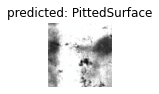

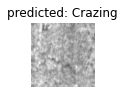

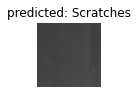

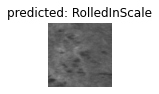

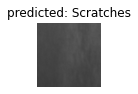

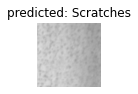

In [78]:
# Predictions by Single Model: VGG11
visualize_model(model_vgg11_full)

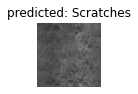

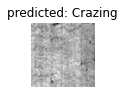

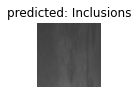

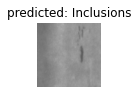

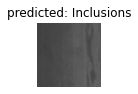

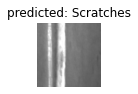

In [75]:
# Predictions by Ensemble Classifier of Resnet50 and Vgg11
visualize_model(model_ens_2_full)

## Part 2: Convolution Neural Network Built and Trained From Scratch

In this part, we're going to compare the previous performance of the pretrained CNN models with a CNN model built layer by layer.

In [1]:
import cv2
from tqdm import tqdm

<span style="color:#008B8B"> <b>Please note</b> that the paths of the database folders below might need to be adjusted to work on your environment.</span>

In [2]:
#Create classes for the image processing of the steel defects 
class SteelDefects():
    IMG_SIZE = 200
    #For this step we need to manually put images from the Databse file in separate files named after the different observed
    #defects
    #That classification is already done in the Database file provided in the Zip file we have sent
    Crazing = 'Database/Crazing'
    Inclusions = 'Database/Inclusions'
    Patches = 'Database/Patches'
    PittedSurface = 'Database/PittedSurface'
    RolledInScale = 'Database/RolledInScale'
    Scratches = 'Database/Scratches'
    #We give class values to the images from the different files
    LABELS = {Crazing : 0 , Inclusions : 1 , Patches : 2, PittedSurface : 3, RolledInScale : 4, Scratches : 5}
    #Creating an empty list, training_data, that will be later filled with the images and their labels
    training_data = []
    
    #Setting counters to 0 (to append training samples to training data)
    CrazingCount = 0
    InclusionsCount = 0
    PatchesCount = 0
    PittedSurfaceCount = 0
    RolledInScaleCount = 0
    ScratchesCount = 0
    
    #Creating the data we will train on by associating images to their right class/label
    def associate_training_data(self):
        for label in self.LABELS:
            #print(label)
            for file in tqdm(os.listdir(label)):
                path = os.path.join(label, file) 
                img = cv2.imread(path, cv2.IMREAD_GRAYSCALE) #read images in grey scale 
                #Resizing of the images as defined before: 200*200
                img = cv2.resize(img, (self.IMG_SIZE, self.IMG_SIZE))
                self.training_data.append([np.array(img), np.eye(6)[self.LABELS[label]]])
                #We want to have a one hot vector format with our labels to index images 
                #We used np.eye(6) which is an 6x6 identity matrix (corresponding to our 6 different labels)
            
                
                if label == self.Crazing:
                            self.CrazingCount += 1
                elif label == self.Inclusions:
                            self.InclusionsCount += 1
                elif label == self.Patches:
                            self.PatchesCount += 1
                elif label == self.PittedSurface:
                            self.PittedSurfaceCount += 1
                elif label == self.RolledInScale:
                            self.RolledInScaleCount += 1
                elif label == self.Scratches:
                            self.ScratchesCount += 1
    
        
        #Shuffling the data that will fill the training_data list
        np.random.shuffle(self.training_data)
        np.save("training_data.npy", self.training_data)
        print('Crazings:',self.CrazingCount)
        print('Inclusions:',self.InclusionsCount)
        print('Patches:',self.PatchesCount)
        print('Pitted Surface:',self.PittedSurfaceCount)
        print('Rolled In Scale:',self.RolledInScaleCount)
        print('Scratches:',self.ScratchesCount)

steeldefects = SteelDefects()
steeldefects.associate_training_data()

    

100%|███████████████████████████████████████████████████████████████████████████████| 300/300 [00:00<00:00, 767.13it/s]


Crazings: 300
Inclusions: 300
Patches: 300
Pitted Surface: 300
Rolled In Scale: 300
Scratches: 300


We observe a perfect balance between classes (300 images per label). It is a necessary condition for our neural network model, which will then not be induced to choose an unbalanced category during its training.

In [3]:
#After setting REBUIlD_DATA to False, we store the training_data as an array in a npy file
training_data = np.load("training_data.npy", allow_pickle = True) 
#Lenght of our training_data
print(len(training_data))

1800


Our sample has 1800 images (300*6 labels)

In [4]:
#printing the pixel matrix and the class of the first image of our sample
print(training_data[0])

[array([[132, 120, 119, ..., 161, 157, 148],
       [126, 128, 126, ..., 178, 177, 163],
       [139, 133, 125, ..., 157, 161, 154],
       ...,
       [142, 144, 170, ..., 154, 159, 148],
       [159, 141, 153, ..., 159, 167, 169],
       [153, 156, 151, ..., 159, 148, 151]], dtype=uint8)
 array([0., 0., 0., 0., 1., 0.])]


The one hot vector is pointing out the class of the first image of the sample.


In [5]:
class Model(nn.Module):
#Building of the model
#We create a class, called Model, that will inherit methods from the nn.Module class
    def __init__(self):
        super().__init__() #The super() function returns an object that represents the parent class
        self.conv1 = nn.Conv2d(1, 32, 3) 
        self.conv2 = nn.Conv2d(32, 64, 3) 
        self.conv3 = nn.Conv2d(64, 128, 3)

        #Creating random data (x), pass it through CNN and reshaping it the right size for passing through the  linear neural network 
        x = torch.randn(200,200).view(-1,1,200,200)
        self._to_linear = None
        self.convs(x)
      
       # Now calling the initialization of the fully connected (fc) neurons network
        self.fc1 = nn.Linear(self._to_linear, 576) 
        self.fc2 = nn.Linear(576, 320) 
        self.fc3 = nn.Linear(320, 6) #output size of 6 as we have 6 differents classes of defects

#Defining the forward method ONLY for the CNN    
    def convs(self, x): 
        x = F.max_pool2d(F.relu(self.conv1(x)), (3, 3)) #pooling with a 3*3 window
        x = F.max_pool2d(F.relu(self.conv2(x)), (3, 3))
        x = F.max_pool2d(F.relu(self.conv3(x)), (3, 3))

        #Making sure that the data passing trough the CNN has the right size before the fc network
        if self._to_linear is None:
            self._to_linear = x[0].shape[0]*x[0].shape[1]*x[0].shape[2]
        return x

#Now defining the entire forward method for the WHOLE model (CNN and linear network)
    def forward(self, x):
        x = self.convs(x) #passing through the convolutional layers
        x = x.view(-1, self._to_linear)  #shaping the data to be flattened
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return F.softmax(x, dim=1)


model = Model()
print(model)

Model(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=4608, out_features=576, bias=True)
  (fc2): Linear(in_features=576, out_features=320, bias=True)
  (fc3): Linear(in_features=320, out_features=6, bias=True)
)


In [6]:
import torch.optim as optim
#Adam Optimizer for a stochastic optimization (learning rate 1e-3)
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_function = nn.MSELoss()

In [7]:
#Separating xs and ys from our data (xs are pixel values, y is the one hot vector)
X = torch.Tensor([i[0] for i in training_data]).view(-1,200,200)
X = X/255.0
y = torch.Tensor([i[1] for i in training_data])

In [8]:
Val_percent = 0.3 # we save 30% of our data for testing
val_size = int(len(X)*Val_percent)
print(val_size)

540


Our validation sample size is 540 images. 

In [9]:
train_X = X[:-val_size]
train_y = y[:-val_size]

test_X = X[-val_size:]
test_y = y[-val_size:]

print(len(train_X))
print(len(test_X))

1260
540


We are training our model on 1260 images and, as seen before, testing it on 540 pictures.

In [10]:
#batch size = 32 and epochs = 15 for training
BATCH_SIZE = 32
EPOCHS = 15 #number of times we pass data through the model to evaluate it

for epoch in range(EPOCHS):
    for i in tqdm(range(0, len(train_X), BATCH_SIZE)): #From 0, with steps = 32, for the lenght of train_X(=1260)
        batch_X = train_X[i:i+BATCH_SIZE].view(-1, 1, 200, 200)
        batch_y = train_y[i:i+BATCH_SIZE]

    
        #Setting gradients to 0 before the loss calculation
        optimizer.zero_grad()   
        outputs = model(batch_X)
        loss = loss_function(outputs, batch_y)
        loss.backward()
        optimizer.step()    #Optimizer adjust the weights to lower the loss over time (learning rate of 1e-3)

    print(f"Epoch: {epoch}. Loss: {loss}")
    


  0%|                                                                                           | 0/40 [00:00<?, ?it/s]

Epoch: 0. Loss: 0.1562793254852295


  0%|                                                                                           | 0/40 [00:00<?, ?it/s]

Epoch: 1. Loss: 0.11358287930488586


  0%|                                                                                           | 0/40 [00:00<?, ?it/s]

Epoch: 2. Loss: 0.07440149784088135


  0%|                                                                                           | 0/40 [00:00<?, ?it/s]

Epoch: 3. Loss: 0.06312646716833115


  0%|                                                                                           | 0/40 [00:00<?, ?it/s]

Epoch: 4. Loss: 0.031805042177438736


  0%|                                                                                           | 0/40 [00:00<?, ?it/s]

Epoch: 5. Loss: 0.0333588570356369


  0%|                                                                                           | 0/40 [00:00<?, ?it/s]

Epoch: 6. Loss: 0.025439513847231865


  0%|                                                                                           | 0/40 [00:00<?, ?it/s]

Epoch: 7. Loss: 0.032403185963630676


  0%|                                                                                           | 0/40 [00:00<?, ?it/s]

Epoch: 8. Loss: 0.031079314649105072


  0%|                                                                                           | 0/40 [00:00<?, ?it/s]

Epoch: 9. Loss: 0.028474221006035805


  0%|                                                                                           | 0/40 [00:00<?, ?it/s]

Epoch: 10. Loss: 0.02782069705426693


  0%|                                                                                           | 0/40 [00:00<?, ?it/s]

Epoch: 11. Loss: 0.02620222605764866


  0%|                                                                                           | 0/40 [00:00<?, ?it/s]

Epoch: 12. Loss: 0.03357209265232086


  0%|                                                                                           | 0/40 [00:00<?, ?it/s]

Epoch: 13. Loss: 0.030377903953194618


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [02:20<00:00,  3.52s/it]

Epoch: 14. Loss: 0.02795458771288395


In [11]:
#Testing the accuracy of the model's prediction
correct = 0
total = 0
#Just evaluating our model accuracy without calculating gradients: using torch.no_grad()
with torch.no_grad(): 
    for i in tqdm(range(len(test_X))):
        real_class = torch.argmax(test_y[i])
        model_out = model(test_X[i].view(-1, 1, 200, 200))[0] 
        predicted_class = torch.argmax(model_out)

        if predicted_class == real_class:
            correct += 1
        total += 1
print("Accuracy: ", round(correct/total*100, 2), "%")

100%|████████████████████████████████████████████████████████████████████████████████| 540/540 [00:48<00:00, 11.22it/s]

Accuracy:  96.3 %


This neural network gives us a <b>96.3%</b> accuracy in predicting the right classes of the steel defects for the 540 tested pictures.